<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/API/Complete_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#start

In [1]:
!pip install retinaface_pytorch &> /dev/null

In [10]:
import os
import random
import cv2 
from retinaface.pre_trained_models import get_model
from retinaface.utils import vis_annotations
from google.colab.patches import cv2_imshow
import glob
import itertools
import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!gdown --id 1mNZ5eaoT9A0LdXLFZcE4lFeM9X6X7Cjt #loading the dataset from google drive link to colab
!unzip /content/rwmfd.zip &> /dev/null #unzipping
!rm -rf /content/rwmfd.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1mNZ5eaoT9A0LdXLFZcE4lFeM9X6X7Cjt
To: /content/rwmfd.zip
157MB [00:01, 128MB/s]


In [4]:
def generate_image_paths(dir_path):
  files_jpg = glob.glob(dir_path + '/**/*.jpg', recursive=True)
  files_jpeg = glob.glob(dir_path + '/**/*.jpeg', recursive=True)
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  files_webp = glob.glob(dir_path + '/**/*.webp', recursive=True)
  files_jfif = glob.glob(dir_path + '/**/*.jfif', recursive=True)
  paths = list(itertools.chain(files_jpg, files_jpeg, files_png, files_webp, files_jfif))
  return paths

dataset_path = "/content/rwmfd"
paths = generate_image_paths(dataset_path)

print(len(paths))

4194


In [5]:
def retinaFace_detector(image_path, detector):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #detector accepts only RGB images
  faces = detector.predict_jsons(image)
  return faces

In [6]:
def openCV_image_cropping(image_path, face):
  img = cv2.imread(image_path)
  crop_img = img[face[1]:face[3], face[0]:face[2]]
  return crop_img

Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_2020-07-20-f168fae3c.zip


/usr/local/lib/python3.7/dist-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


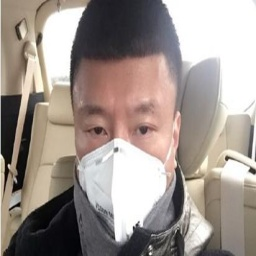

[{'bbox': [70, 57, 172, 209], 'score': 0.9999110698699951, 'landmarks': [[98, 129], [144, 128], [122, 162], [108, 184], [141, 182]]}]


In [7]:
detector = get_model("resnet50_2020-07-20", max_size=1024) #value of max_size ?? predition time depends on this
detector.eval()


random_image_path = random.choice(paths)
random_image = cv2.imread(random_image_path)
cv2_imshow(random_image)
faces = retinaFace_detector(random_image_path, detector)
print(faces)

{'bbox': [70, 57, 172, 209], 'score': 0.9999110698699951, 'landmarks': [[98, 129], [144, 128], [122, 162], [108, 184], [141, 182]]}


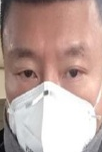

In [8]:
for face in faces:
  print(face)
  if face != [] and face["score"] > 0.95:
    cropped_face = openCV_image_cropping(random_image_path, face["bbox"])
    cv2_imshow(cropped_face)

In [25]:
detected_faces = {}

random.shuffle(paths)

# size set to 10 random images, make sure to change this while working on problem statement
# detecting - this might take a while
i = 0
for image_path in paths[:20]:
  faces = retinaFace_detector(image_path, detector)
  for face in faces:
    if face != [] and face["score"] > 0.95:
      cropped_face = openCV_image_cropping(image_path, face["bbox"])
      cropped_face_path = "/content/test_images/" + str(i) + ".png"
      i += 1
      cv2.imwrite(cropped_face_path,cropped_face)
      detected_faces.setdefault(image_path, []).append(cropped_face_path)

# displaying
# for (image_path, faces) in detected_faces.items():
#   cv2_imshow(cv2.imread(image_path))
#   for face in faces:
#     print(face)
#     if face != []:
#       cropped_face = openCV_image_cropping(image_path, face)
#       cv2_imshow(cropped_face)

# len(detected_faces)

In [ ]:
!mkdir test_images

In [32]:
# Complete Model 

class CModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()

  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(inputs)
    layer2 = tf.keras.layers.Flatten()(layer1)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(layer2)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def predict_single(self, image_path):
    Image = cv2.imread(image_path)
    cv2_imshow(Image)
    image = tf.keras.preprocessing.image.load_img(image_path, grayscale=False, color_mode="rgb", target_size=(153, 153), interpolation="bilinear")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    prediction = self.model.predict(input_arr, verbose = 1)
    if(prediction[0] >= 0.5):
      return 1
    else:
      return 0

  def readModelFromFile(self,file_path):
    self.model.load_weights(file_path) 

In [33]:
Complete_Model = CModel((153,153,3))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 153, 153, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 2)       98        
_________________________________________________________________
flatten_3 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 45001     
Total params: 45,099
Trainable params: 45,099
Non-trainable params: 0
_________________________________________________________________


In [34]:
Complete_Model.readModelFromFile("/content/model0.h5")

1/1 [==============================] - 0s 50ms/step
1


1/1 [==============================] - 0s 16ms/step
1


1/1 [==============================] - 0s 16ms/step
1


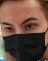

1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 16ms/step
1


1/1 [==============================] - 0s 16ms/step
1


1/1 [==============================] - 0s 18ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 20ms/step
1


1/1 [==============================] - 0s 18ms/step
1


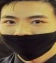

1/1 [==============================] - 0s 16ms/step
0


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 16ms/step
1


1/1 [==============================] - 0s 18ms/step
1


1/1 [==============================] - 0s 18ms/step
1


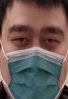

1/1 [==============================] - 0s 18ms/step
1


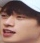

1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 23ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


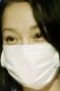

1/1 [==============================] - 0s 17ms/step
1


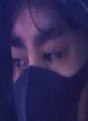

1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 18ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 17ms/step
1


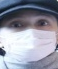

1/1 [==============================] - 0s 18ms/step
1


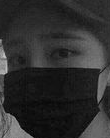

1/1 [==============================] - 0s 19ms/step
0


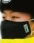

1/1 [==============================] - 0s 18ms/step
0


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 19ms/step
1


1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 18ms/step
1


In [35]:
for parent_path,child_paths in detected_faces.items():
  for child_path in child_paths:
    print(Complete_Model.predict_single(child_path))
